<a href="https://colab.research.google.com/github/gusibi/oneplus/blob/master/text_to_image_with_lora_and_controlnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Install requirement
from google.colab import drive
drive.mount('/content/drive')

%pip install --quiet --upgrade diffusers transformers accelerate safetensors mediapy triton scipy ftfy spacy>=3.5.0
# The xformers package is mandatory to be able to create several 768x768 images.
%pip install -q xformers==0.0.16rc425

# controlnet requirement
%pip install opencv-contrib-python
%pip install controlnet_aux

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.5 MB/s eta 0:00:00


In [2]:
#@title Convert lora safetensor to diffusers
# https://github.com/huggingface/diffusers/blob/main/scripts/convert_lora_safetensor_to_diffusers.py
!pip install safetensors
!pip install --quiet --upgrade diffusers transformers accelerate safetensors mediapy triton scipy ftfy spacy==3.4.4
# The xformers package is mandatory to be able to create several 768x768 images.
!%pip install -q xformers==0.0.16rc425
import os


def convert(
    base_model_path, checkpoint_path, LORA_PREFIX_UNET, LORA_PREFIX_TEXT_ENCODER, alpha
):
    # base_model_path             default=None, type=str, required=True, help="Path to the base model in diffusers format."    runwayml/stable-diffusion-v1-5
    # checkpoint_path             default=None, type=str, required=True, help="Path to the checkpoint to convert." lora model path
    # LORA_PREFIX_UNET            default="lora_unet", type=str, help="The prefix of UNet weight in safetensors"
    # LORA_PREFIX_TEXT_ENCODER    default="lora_te",type=str, help="The prefix of text encoder weight in safetensors",
    # alpha                       default=0.75,  type=float, help="The merging ratio in W = W0 + alpha * deltaW")
    import torch
    from safetensors.torch import load_file
    from diffusers import StableDiffusionPipeline

    # load base model
    pipeline = StableDiffusionPipeline.from_pretrained(
        base_model_path, torch_dtype=torch.float32
    )

    # load LoRA weight from .safetensors
    state_dict = load_file(checkpoint_path)

    visited = []

    # directly update weight in diffusers model
    for key in state_dict:
        # it is suggested to print out the key, it usually will be something like below
        # "lora_te_text_model_encoder_layers_0_self_attn_k_proj.lora_down.weight"

        # as we have set the alpha beforehand, so just skip
        if ".alpha" in key or key in visited:
            continue

        if "text" in key:
            layer_infos = (
                key.split(".")[0].split(LORA_PREFIX_TEXT_ENCODER + "_")[-1].split("_")
            )
            curr_layer = pipeline.text_encoder
        else:
            layer_infos = key.split(".")[0].split(LORA_PREFIX_UNET + "_")[-1].split("_")
            curr_layer = pipeline.unet

        # find the target layer
        temp_name = layer_infos.pop(0)
        while len(layer_infos) > -1:
            try:
                curr_layer = curr_layer.__getattr__(temp_name)
                if len(layer_infos) > 0:
                    temp_name = layer_infos.pop(0)
                elif len(layer_infos) == 0:
                    break
            except Exception:
                if len(temp_name) > 0:
                    temp_name += "_" + layer_infos.pop(0)
                else:
                    temp_name = layer_infos.pop(0)

        pair_keys = []
        if "lora_down" in key:
            pair_keys.append(key.replace("lora_down", "lora_up"))
            pair_keys.append(key)
        else:
            pair_keys.append(key)
            pair_keys.append(key.replace("lora_up", "lora_down"))

        # update weight
        if len(state_dict[pair_keys[0]].shape) == 4:
            weight_up = state_dict[pair_keys[0]].squeeze(3).squeeze(2).to(torch.float32)
            weight_down = (
                state_dict[pair_keys[1]].squeeze(3).squeeze(2).to(torch.float32)
            )
            curr_layer.weight.data += alpha * torch.mm(
                weight_up, weight_down
            ).unsqueeze(2).unsqueeze(3)
        else:
            weight_up = state_dict[pair_keys[0]].to(torch.float32)
            weight_down = state_dict[pair_keys[1]].to(torch.float32)
            curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down)

        # update visited list
        for item in pair_keys:
            visited.append(item)

    return pipeline


def convert_lora_to_diffuser(
    base_model_path,
    lora_model_path,
    dump_path,
    lora_prefix_unet="lora_unet",
    lora_prefix_text_encoder="lora_te",
    alpha=0.75,
    device="cuda",
    to_safetensors=True,
):
    # base_model_path             default=None, type=str, required=True, help="Path to the base model in diffusers format."    runwayml/stable-diffusion-v1-5
    # lora_model_path             default=None, type=str, required=True, help="Path to the checkpoint to convert." lora model path
    # dump_path"                  default=None, type=str, required=True, help="Path to the output model."
    # lora_prefix_unet             default="lora_unet", type=str, help="The prefix of UNet weight in safetensors"
    # lora_prefix_text_encoder     default="lora_te",type=str, help="The prefix of text encoder weight in safetensors",
    # alpha                       default=0.75,  type=float, help="The merging ratio in W = W0 + alpha * deltaW"
    # device                      default="cuda"  type=str, help="Device to use (e.g. cpu, cuda:0, cuda:1, etc.)"
    # to_safetensors              default=True, help="Whether to store pipeline in safetensors format or not."
    print("start convert")
    print(f"base_model_path: {base_model_path}")
    print(f"lora_model_path: {lora_model_path}")
    print(f"dump_path: {dump_path}")
    print(f"lora_prefix_unet: {lora_prefix_unet}")
    print(f"lora_prefix_text_encoder: {lora_prefix_text_encoder}")
    print(f"alpha: {alpha}")
    print(f"device: {device}")
    print(f"to_safetensors: {to_safetensors}")

    alpha = 0.75
    pipe = convert(
        base_model_path,
        lora_model_path,
        lora_prefix_unet,
        lora_prefix_text_encoder,
        alpha,
    )
    print("convert processing")
    pipe = pipe.to(device)

    to_safetensors = False
    print("saving model")
    pipe.save_pretrained(dump_path, safe_serialization=to_safetensors)
    print(f"saving model to {dump_path} success")


base_model_path = "windwhinny/chilloutmix" # @param
lora_model_path = "/content/drive/MyDrive/AI/trained/lora/aki.safetensors" # @param
dump_path = "/content/outputs/aki" # @param

if not os.path.exists(dump_path):
    os.makedirs(dump_path)

convert_lora_to_diffuser(
    base_model_path=base_model_path,
    lora_model_path=lora_model_path,
    dump_path=dump_path,
)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 64.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.5.0 requires spacy<3.6.0,>=3.5.0, but you have spacy 3.4.4 which is incompatible.
/bin/bash: line 0: fg: no job control
start convert
base_model_path: windwhinny/chilloutmix
lora_model_path: /content/drive/MyDrive/AI/trained/lora/aki.safetensors
dump_path: /content/outputs/aki
lora_prefix_unet: lora_unet
lora_prefix_text_encoder: lora_te
alpha: 0.75
device: cuda
to_safetensors: True


unet/diffusion_pytorch_model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


convert processing
saving model
saving model to /content/outputs/aki success


In [ ]:
#@title Load LoRA Model

from diffusers import StableDiffusionPipeline
import torch
model_path = "/content/outputs/aki" # @param

pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float32)
pipe.to("cuda")


In [ ]:
#@title Generate image by text
import mediapy as media
import datetime

now = datetime.datetime.now()
time_str = now.strftime("%Y-%m-%d-%H:%M:%S")
print(time_str)

prompt = "1 girl, <lora:aki:0.2>, wanostyle,  smiling, looking at sky." # @param
height = 512 # @param
width = 512 # @param
num_inference_steps = 30 # @param
guidance_scale = 8 # @param
output_image_path = "/content/drive/MyDrive/SD Outputs"  # @param
output_image_name = "image.png"  # @param
image_name = "%s-%s" % (time_str, output_image_name)


images = pipe(prompt, 
              height=height, 
              width=width,
              num_inference_steps=num_inference_steps, 
              guidance_scale=guidance_scale).images

media.show_images(images)
images[0].save("%s/%s" % (output_image_path, image_name))

In [3]:
#@title Install Controlnet Requirement
!pip install opencv-contrib-python
!pip install controlnet_aux

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.3 MB/s eta 0:00:00


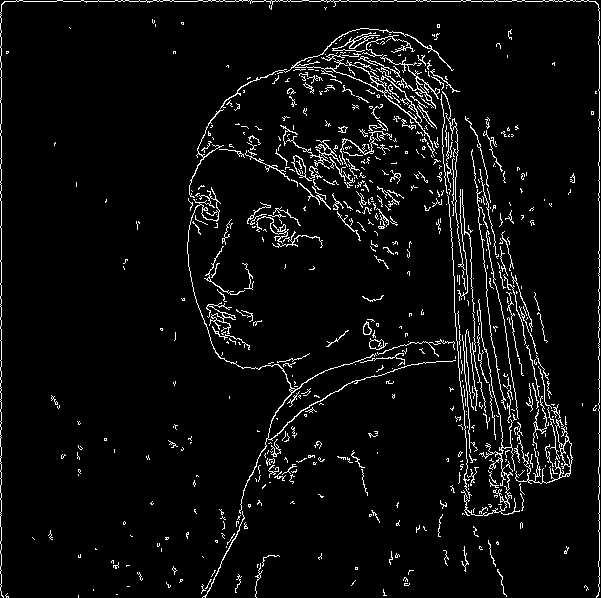

In [9]:
#@title canny pre-processor

import cv2
from PIL import Image
import numpy as np
from diffusers.utils import load_image

input_image = "/content/drive/MyDrive/AI/training/Girl-with-a-Pearl-Earring.jpeg" # @param
image = load_image(input_image)
image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

In [ ]:
#@title Load ControlNet Model With controlnet-canny
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers import UniPCMultistepScheduler
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)

model_path = "/content/outputs/aki" # @param

pipe = StableDiffusionControlNetPipeline.from_pretrained(model_path, controlnet=controlnet, torch_dtype=torch.float16)
# 这里我们不使用 Stable Diffusion 默认的 PNDMScheduler 调度器，而使用改进的 UniPCMultistepScheduler (目前最快的扩散模型调度器之一)，可以极大地加快推理速度。
# 经测试，在保证生成图像质量的同时，我们能将推理阶段的采样步数从 50 降到 20
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
#  启用 enable_model_cpu_offload 后，pipeline 会自动进行 GPU 内存管理，因此请不要再使用 .to("cuda") 手动将 pipeline 转移到 GPU
pipe.enable_model_cpu_offload()
# 最后，我们要充分利用 FlashAttention/xformers 进行注意力层加速。
# 运行下列代码以实现加速，如果该代码没有起作用，那么您可能没有正确安装 xformers 库，此时您可以跳过该代码。
pipe.enable_xformers_memory_efficient_attention()


In [ ]:
#@title Text to Image with canny
from PIL import Image

prompt = ", best quality, extremely detailed"
prompt = [t + prompt for t in ["Sandra Oh", "Kim Kardashian", "rihanna", "taylor swift"]] # 分别为: 吴珊卓、金·卡戴珊、蕾哈娜、泰勒·斯威夫特
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    num_inference_steps=20,
    generator=generator,
)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

image_grid(output.images, 2, 2)

In [ ]:
#@title Load ControlNet Model With controlnet-openpose

from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers import UniPCMultistepScheduler
import torch


controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
model_path = "/content/outputs/aki" # @param

pipe = StableDiffusionControlNetPipeline.from_pretrained(model_path, controlnet=controlnet, torch_dtype=torch.float16)
# 这里我们不使用 Stable Diffusion 默认的 PNDMScheduler 调度器，而使用改进的 UniPCMultistepScheduler (目前最快的扩散模型调度器之一)，可以极大地加快推理速度。
# 经测试，在保证生成图像质量的同时，我们能将推理阶段的采样步数从 50 降到 20
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
#  启用 enable_model_cpu_offload 后，pipeline 会自动进行 GPU 内存管理，因此请不要再使用 .to("cuda") 手动将 pipeline 转移到 GPU
pipe.enable_model_cpu_offload()
# 最后，我们要充分利用 FlashAttention/xformers 进行注意力层加速。
# 运行下列代码以实现加速，如果该代码没有起作用，那么您可能没有正确安装 xformers 库，此时您可以跳过该代码。
pipe.enable_xformers_memory_efficient_attention()


In [ ]:
#@title openpose pre-processor
from PIL import Image

from diffusers.utils import load_image
from controlnet_aux import OpenposeDetector


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


urls = "yoga1.jpeg", "yoga2.jpeg", "yoga3.jpeg", "yoga4.jpeg"
imgs = [
    load_image("https://huggingface.co/datasets/YiYiXu/controlnet-testing/resolve/main/" + url) 
    for url in urls
]

image_grid(imgs, 2, 2)


model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

poses = [model(img) for img in imgs]
image_grid(poses, 2, 2)

generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(4)]
prompt = "High detail RAW color photo professional, highly detail face: 1.4, a detailed portrait of a woman floating underwater wearing long flowing dress, nymph style, amazing underwater, detailed skin, wet clothes, wet hair, see-through clothes, lens flare, shade, tindal effect, lens flare, backlighting, bokeh" # @param
output = pipe(
    [prompt] * 4,
    poses,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    generator=generator,
    num_inference_steps=50,
)
image_grid(output.images, 2, 2)

In [15]:
#@title depth pre-processor(A grayscale image with black representing deep areas and white representing shallow areas.)

from transformers import pipeline
from PIL import Image, ImageOps
import numpy as np
from diffusers.utils import load_image

depth_estimator = pipeline('depth-estimation')

image = load_image("/content/drive/MyDrive/SDOutputs/2023-03-28-145004-image021.png")

image = depth_estimator(image)['depth']
image = np.array(image)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
image = Image.fromarray(image)
image.save("mask_image.png")
mask_image = ImageOps.invert(image)


No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [16]:
#@title invert image colors

from PIL import Image, ImageOps

def invert_colors(image_path, output_path):
    # 打开图片
    img = Image.open(image_path)

    # 反转图片颜色
    inverted_img = ImageOps.invert(img)

    # 保存反转后的图片
    inverted_img.save(output_path)

invert_colors = invert_colors("mask_image.png", "mask_image_r1.png")

In [ ]:
#@title text to image by controlnet-depth

from transformers import pipeline
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from PIL import Image
import numpy as np
import torch
from diffusers.utils import load_image

depth_estimator = pipeline('depth-estimation')

image = load_image("https://huggingface.co/lllyasviel/sd-controlnet-depth/resolve/main/images/stormtrooper.png")

image = depth_estimator(image)['depth']
image = np.array(image)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
image = Image.fromarray(image)

controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-depth", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

pipe.enable_model_cpu_offload()

image = pipe("Stormtrooper's lecture", image, num_inference_steps=20).images[0]

image.save('./images/stormtrooper_depth_out.png')

In [20]:
#@title 使用 face_recognition 将脸部涂成白色【简陋】
%pip install face_recognition pillow

import face_recognition
from PIL import Image, ImageDraw

def whiteout_faces(image_path, output_path):
    # 加载图片
    image = face_recognition.load_image_file(image_path)
    pil_image = Image.fromarray(image)

    # 检测人脸
    face_locations = face_recognition.face_locations(image)

    # 在PIL图像上绘制
    draw = ImageDraw.Draw(pil_image)

    # 遍历检测到的人脸
    for face_location in face_locations:
        top, right, bottom, left = face_location

        # 将人脸涂成白色
        draw.rectangle([(left, top), (right, bottom)], fill=(255, 255, 255))

    # 保存处理后的图片
    pil_image.save(output_path)

whiteout_faces("/content/drive/MyDrive/SDOutputs/2023-03-28-145004-image021.png", "without_face.jpg")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
text_encoder/model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

,,

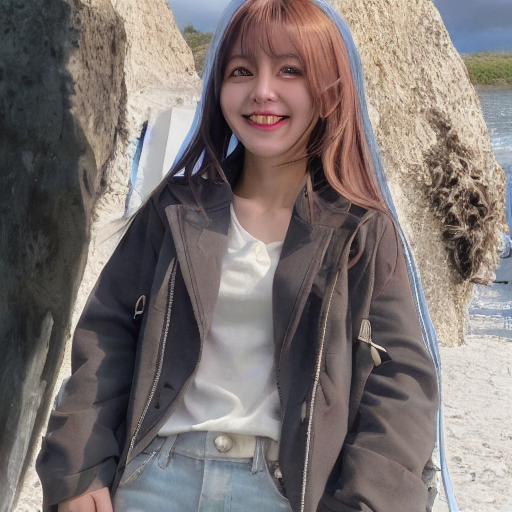
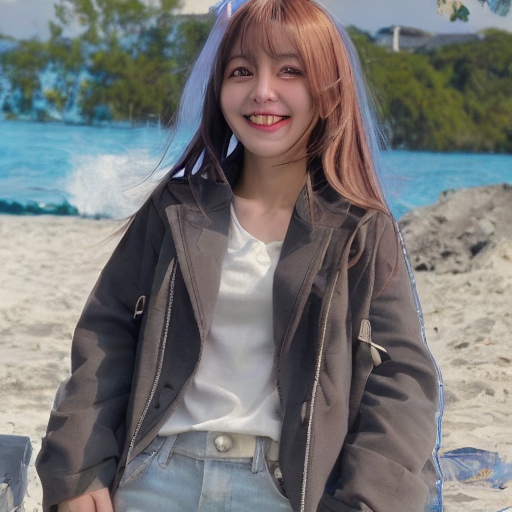
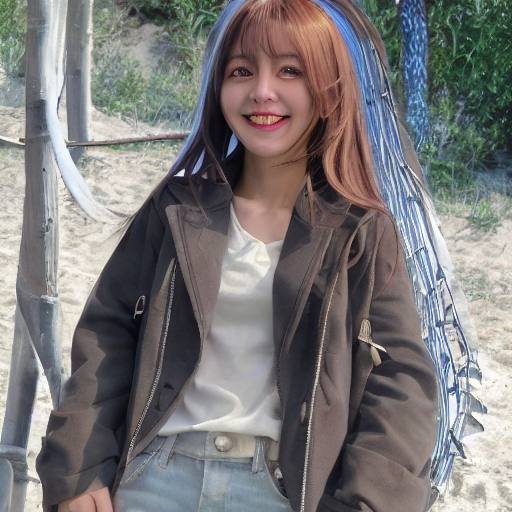

In [17]:
#@title in painting with controlnet depth image
import mediapy as media
from transformers import pipeline
from PIL import Image, ImageOps
import numpy as np
from diffusers.utils import load_image

depth_estimator = pipeline('depth-estimation')

image = load_image("/content/drive/MyDrive/SDOutputs/2023-03-28-145004-image021.png")

depth_image = depth_estimator(image)['depth']
depth_image = np.array(depth_image)
depth_image = depth_image[:, :, None]
depth_image = np.concatenate([depth_image, depth_image, depth_image], axis=2)
depth_image = Image.fromarray(depth_image)

mask_image = ImageOps.invert(depth_image)

import inspect
from typing import List, Optional, Union

import torch

from diffusers import StableDiffusionInpaintPipeline

device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

prompt = "1 girl on the beatch"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images
media.show_images(images)

  0%|          | 0/50 [00:00<?, ?it/s]

,,

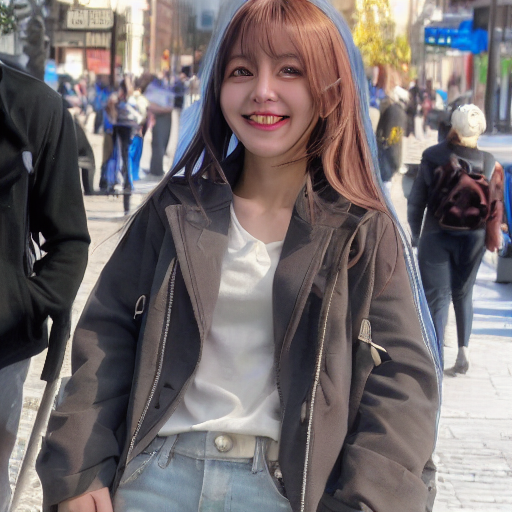
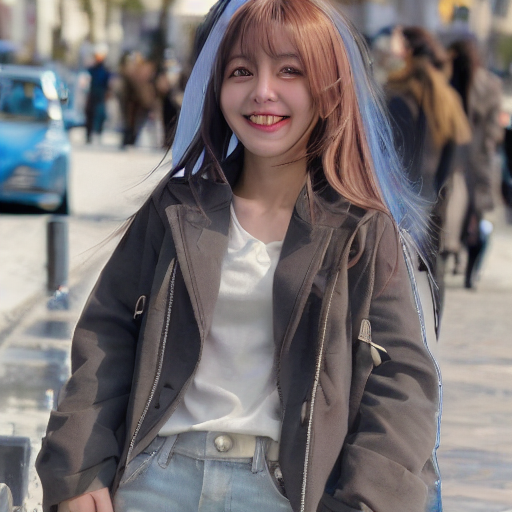
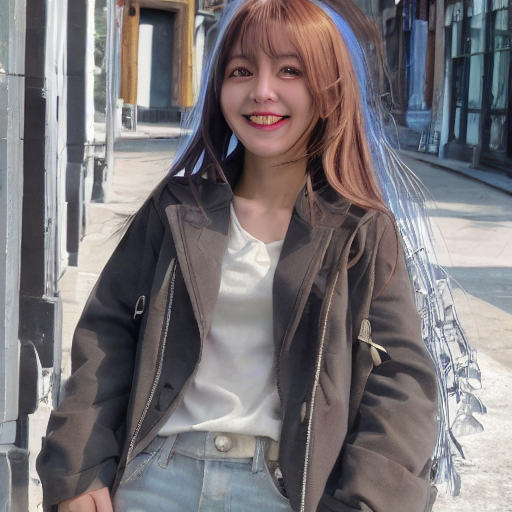

In [18]:
prompt = "A girl is walking on the street"

guidance_scale=7.5
num_samples = 2
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images
media.show_images(images)

# test code

In [ ]:
!pip install safetensors mediapy
"""
This script shows a naive way, may be not so elegant, to load Lora (safetensors) weights in to diffusers model
For the mechanism of Lora, please refer to https://github.com/cloneofsimo/lora
Copyright 2023: Haofan Wang, Qixun Wang
"""

#!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/ckpt/chilloutmix/resolve/main/chilloutmix_NiPrunedFp32Fix.safetensors -d /content/models -o chilloutmix_NiPrunedFp32Fix.safetensors

import torch
import mediapy as media
from safetensors.torch import load_file
from diffusers import StableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler

# load diffusers model
model_id = "runwayml/stable-diffusion-v1-5"
model_id = "/content/models/chilloutmix_NiPrunedFp32Fix.safetensors"
model_id = "windwhinny/chilloutmix"
pipeline = StableDiffusionPipeline.from_pretrained(model_id,torch_dtype=torch.float32)
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)

# load lora weight
model_path = "/content/lora/aki.safetensors"
state_dict = load_file(model_path)

LORA_PREFIX_UNET = 'lora_unet'
LORA_PREFIX_TEXT_ENCODER = 'lora_te'

alpha = 0.75

visited = []

# directly update weight in diffusers model
for key in state_dict:
    
    # it is suggested to print out the key, it usually will be something like below
    # "lora_te_text_model_encoder_layers_0_self_attn_k_proj.lora_down.weight"
    
    # as we have set the alpha beforehand, so just skip
    if '.alpha' in key or key in visited:
        continue
        
    if 'text' in key:
        layer_infos = key.split('.')[0].split(LORA_PREFIX_TEXT_ENCODER+'_')[-1].split('_')
        curr_layer = pipeline.text_encoder
    else:
        layer_infos = key.split('.')[0].split(LORA_PREFIX_UNET+'_')[-1].split('_')
        curr_layer = pipeline.unet

    # find the target layer
    temp_name = layer_infos.pop(0)
    while len(layer_infos) > -1:
        try:
            curr_layer = curr_layer.__getattr__(temp_name)
            if len(layer_infos) > 0:
                temp_name = layer_infos.pop(0)
            elif len(layer_infos) == 0:
                break
        except Exception:
            if len(temp_name) > 0:
                temp_name += '_'+layer_infos.pop(0)
            else:
                temp_name = layer_infos.pop(0)
    
    # org_forward(x) + lora_up(lora_down(x)) * multiplier
    pair_keys = []
    if 'lora_down' in key:
        pair_keys.append(key.replace('lora_down', 'lora_up'))
        pair_keys.append(key)
    else:
        pair_keys.append(key)
        pair_keys.append(key.replace('lora_up', 'lora_down'))
    
    # update weight
    if len(state_dict[pair_keys[0]].shape) == 4:
        weight_up = state_dict[pair_keys[0]].squeeze(3).squeeze(2).to(torch.float32)
        weight_down = state_dict[pair_keys[1]].squeeze(3).squeeze(2).to(torch.float32)
        curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down).unsqueeze(2).unsqueeze(3)
    else:
        weight_up = state_dict[pair_keys[0]].to(torch.float32)
        weight_down = state_dict[pair_keys[1]].to(torch.float32)
        curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down)
        
     # update visited list
    for item in pair_keys:
        visited.append(item)

pipeline = pipeline.to(torch.float16).to("cuda")
pipeline.safety_checker = lambda images, clip_input: (images, False)

prompt = '1 girl, wanostyle, monkey d luffy, smiling, straw hat, looking at viewer, solo, upper body, ((masterpiece)), (best quality), (extremely detailed), depth of field, sketch, dark intense shadows, sharp focus, soft lighting, hdr, colorful, good composition, fire all around, spectacular, <lora:aki:1>, closed shirt, anime screencap, scar under eye, ready to fight, black eyes'
negative_prompt = '(painting by bad-artist-anime:0.9), (painting by bad-artist:0.9), watermark, text, error, blurry, jpeg artifacts, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, artist name, (worst quality, low quality:1.4), bad anatomy, watermark, signature, text, logo'

with torch.no_grad():
    image = pipeline(prompt=prompt,
                     height=512, 
                     width=512,
                     num_inference_steps=50,
                     guidance_scale=8).images[0]

fileName = "./{}_{}1.png".format(prompt[:10],alpha)

# media.show_images([fileName])
image.save(fileName)

In [ ]:
from diffusers import PNDMScheduler, DDIMScheduler, LMSDiscreteScheduler, EulerDiscreteScheduler, DPMSolverMultistepScheduler
# model_id = "stabilityai/stable-diffusion-2-1-base"
# model_id = "stabilityai/stable-diffusion-2-1"
model_id = "dreamlike-art/dreamlike-photoreal-2.0"
scheduler = None
# scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = LMSDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")
     

In [ ]:
import mediapy as media
import torch
from diffusers import StableDiffusionPipeline

device = "cuda"

if model_id.startswith("stabilityai/"):
  model_revision = "fp16"
else:
  model_revision = None

if scheduler is None:
  pipe = StableDiffusionPipeline.from_pretrained(
      model_id,
      torch_dtype=torch.float16,
      revision=model_revision,
      )  
else:
  pipe = StableDiffusionPipeline.from_pretrained(
      model_id,
      scheduler=scheduler,
      torch_dtype=torch.float16,
      revision=model_revision,
      )

pipe = pipe.to(device)
pipe.enable_xformers_memory_efficient_attention()

if model_id.endswith('-base'):
  image_length = 512
else:
  image_length = 768


In [ ]:
prompt = "a photo of Pikachu fine dining with a view to the Eiffel Tower"
remove_safety = False
num_images = 4

if remove_safety:
  negative_prompt = None
  pipe.safety_checker = None
else:
  negative_prompt = "nude, naked"

images = pipe(
    prompt,
    height = image_length,
    width = image_length,
    num_inference_steps = 25,
    guidance_scale = 9,
    num_images_per_prompt = num_images,
    negative_prompt = negative_prompt,
    ).images
    
media.show_images(images)
images[0].save("output.jpg")